In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tqdm.notebook as tqdm

from aes.aes import AES, dump_state, compare_hex, reverse_expand_key
import aes.aes as aes

# nice size for notebook
figsize = (13,5)

# some helper to build data representations
def prepare_data(data):
    df = pd.DataFrame(data)
    cat = pd.Categorical(data, categories=range(256))

    slices = 10
    step = len(df) // slices
    data2 = []
    for sub in range(step, len(data), step):
        tmp = pd.Categorical(df[:sub][0], categories=range(256)).value_counts()
        for b,v in tmp.iteritems():
            data2.append((sub,b,v/sub))

            
    over_time = pd.DataFrame(columns=['#cipher', 'byte', 'count'], data=data2)        
    
    return df, cat, over_time

In [2]:
# collect a reference pair in,out
ctx = AES(range(16))
sample_in = bytes(list(range(16)))
sample_out = ctx.encrypt_block(sample_in)
print('sample_in ', sample_in.hex())
print('sample_out', sample_out.hex())

sample_in  000102030405060708090a0b0c0d0e0f
sample_out 0a940bb5416ef045f1c39458c653ea5a


In [3]:
# setup faulty sbox
try:
    aes.s_box = original_sbox    
except NameError:
    pass

original_sbox = list(aes.s_box)
faulty_sbox = list(aes.s_box)
faultidx = os.urandom(1)[0]
original_sbox_byte = original_sbox[faultidx]
faulty_sbox[faultidx] = faulty_sbox[faultidx] ^ os.urandom(1)[0]
aes.s_box = faulty_sbox
print('faulty_out', ctx.encrypt_block(sample_in).hex())

faulty_out 0a94c4b5417df045d9c39458c653eaf8


In [4]:
# # generate data based on c <= SBox(x) ^ k
# data = [aes.s_box[os.urandom(1)[0]] ^ k for _ in tqdm.trange(20000)]
# df, cat, over_time = prepare_data(data)

# # find the key byte
# tmin = cat.value_counts().idxmin()
# print(f'{tmin:02x} occured {cat.value_counts()[tmin]} times, matching key is {tmin ^ original_sbox_byte:02x}')

# # histogram of the observed output c
# ax = df.plot(kind='hist', bins=256, figsize=figsize, title='Histogram per observed c')

# # plot over increasing amount of cipher texts
# fig, ax = plt.subplots(figsize=figsize)
# ax.set_title('Probability per byte over increasing #cipher')
# for b in tqdm.tqdm(over_time['byte'].unique()):
#     (over_time[over_time['byte']==b]).plot(x='#cipher', y='count', ax=ax, legend=False)

In [5]:
# collect 10k faulty AES computations with SBox[0] == 0x63 ^ 0x8
ctx = AES(range(16))
Ncipher = int(5e3)
data2 = []
for _ in tqdm.trange(Ncipher):
    data2.append(ctx.encrypt_block(os.urandom(16)))
data2 = np.array(list(map(bytearray, data2)))

In [6]:
# prepare data per key byte index
cat_per_kbidx = []
over_time_per_kbidx = []
candidates = []

for kbidx in tqdm.trange(16):
    df, cat, over_time = prepare_data(data2.transpose()[kbidx])
    cat_per_kbidx.append(cat)
    over_time_per_kbidx.append(over_time)
    
    # find the key byte
    tmin = cat.value_counts().idxmin()
    kbidx_candidates = []
    for sboxidx in range(256):
        kbidx_candidates.append(tmin ^ original_sbox[sboxidx])
    candidates.append(kbidx_candidates)
    
    # cheat if you know which sbox entry was corrupted
    print(f'{tmin:02x} occured {cat.value_counts()[tmin]} times, matching key is {tmin ^ original_sbox_byte:02x}')

candidates = np.array(list(map(bytearray, candidates))).transpose()

d0 occured 0 times, matching key is 13
d2 occured 0 times, matching key is 11
de occured 0 times, matching key is 1d
bc occured 0 times, matching key is 7f
20 occured 0 times, matching key is e3
57 occured 0 times, matching key is 94
89 occured 0 times, matching key is 4a
d4 occured 0 times, matching key is 17
30 occured 0 times, matching key is f3
c4 occured 0 times, matching key is 07
64 occured 0 times, matching key is a7
48 occured 0 times, matching key is 8b
8e occured 0 times, matching key is 4d
e8 occured 0 times, matching key is 2b
f3 occured 0 times, matching key is 30
06 occured 0 times, matching key is c5



In [7]:
cat_per_kbidx = []
candidates = []
for kbidx in tqdm.trange(16):
    df, cat, over_time = prepare_data(data2.transpose()[kbidx])
    cat_per_kbidx.append(cat)
    tmin = cat.value_counts().idxmin()

    kbidx_candidates = []
    for sboxidx in range(256):
        kbidx_candidates.append(tmin ^ original_sbox[sboxidx])
    candidates.append(kbidx_candidates)

candidates = np.array(list(map(bytearray, candidates))).transpose()

In [20]:
# restore original sbox to evaluate guesses
aes.s_box = original_sbox

found = False
rk10 = None
for ctr, candidate in enumerate(candidates):
    key = reverse_expand_key(bytes(candidate))[0]
    if AES(key).encrypt_block(sample_in) == sample_out:
        found = True
        rk10 = candidate
        print(key.hex(),'<- correct key, candidate',ctr)
        break

if not found:
    print('correct key not found')

000102030405060708090a0b0c0d0e0f <- correct key, candidate 51


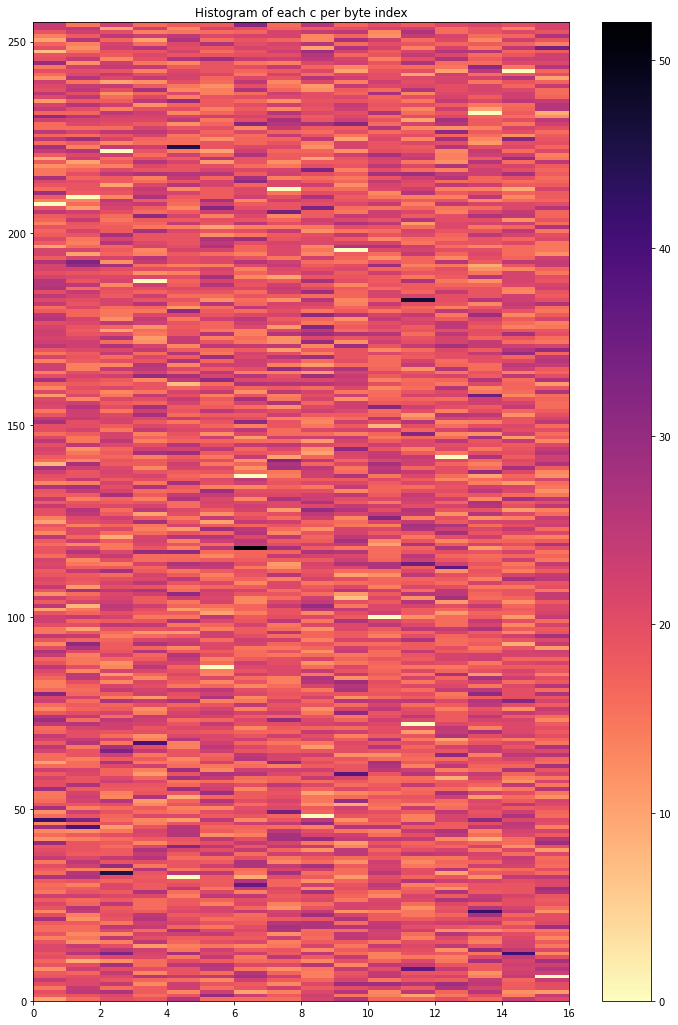

In [9]:
# a histogram of all the key bytes
# should see one white and one black line per byte index
df = pd.DataFrame(columns=['cbyte', 'kbidx'])
for kbidx in range(16):
    col = data2.transpose()[kbidx]
    tmp = np.array([col, [kbidx]*len(col)]).transpose()
    tmp = pd.DataFrame(tmp, columns=['cbyte', 'kbidx'])
    df = df.append(tmp)

fig, ax = plt.subplots()
fig.set_size_inches(12, 18)
ax.set_title('Histogram of each c per byte index')
cmap = plt.cm.magma_r
h = ax.hist2d(df['kbidx'], df['cbyte'], bins=(range(17),256), cmap=cmap, alpha=1)
fig.colorbar(h[3])

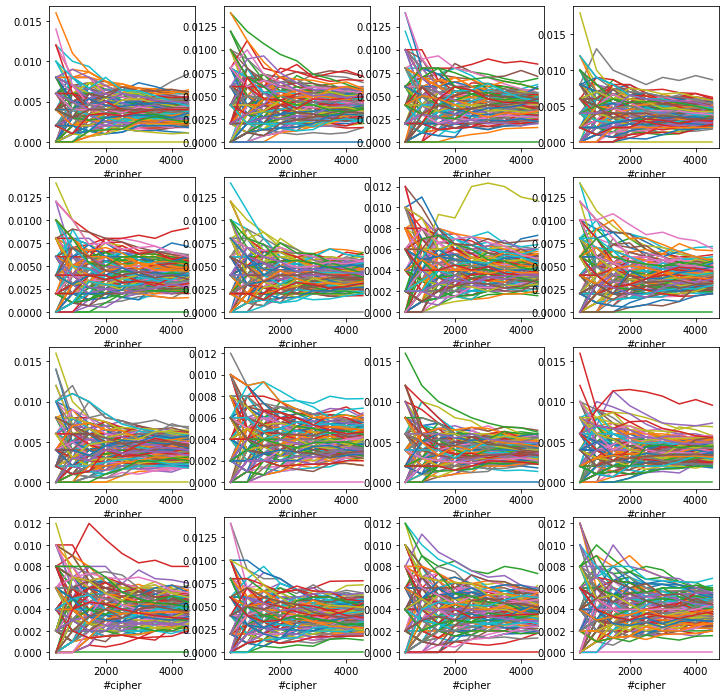

In [10]:
# evolution of probability per ciphertext byte over #ciphers
# in ideal case, exactly one stays zero, which can be used
# to figure out the key
fig, axes = plt.subplots(4,4)
fig.set_size_inches(12, 12)

for kbidx, ax in tqdm.tqdm(enumerate(axes.ravel()), total=16):
    ot = over_time_per_kbidx[kbidx]
    for b in ot['byte'].unique():
        (ot[ot['byte']==b]).plot(x='#cipher', y='count', ax=ax, legend=False)